# The Shallow Ice Approximation


![SIA figure](shallow_ice_approximation_figure_1.jpg)




Is ice a solid or a fluid? 

In fact, solids and fluids are often not mutually exclusive categories. The distinction, instead, is a matter of timescale. If you take an ice cube out of your freezer and hit it with a hammer, it shatters like glass, exhibiting the trademark brittle behaviour of elastic solids. However, if you applied the same force gradually, that ice cube would slowly deform as if it were made of molasses. 

Glaciers behave the same way. Although intense forces can result in sudden, solid-like behaviour - like crevassing and iceberg calving - over long timespans, glaciers behave like thick, viscous fluids oozing outward under the force of their own weight. The laws that govern glacier dynamics, therefore, are the same laws that govern fluid dynamics. These are called the Navier-Stokes Equations, and they are notoriously hard to solve. In fact, there is a standing million-dollar prize for anyone who can prove the existence of a general solution to these equations. Modeling a single glacier with the full Navier-Stokes Equations can take weeks.

Instead, glaciologists often consider approximations to these equations, where terms deemed "unimportant" in certain environments are left out. This vastly simplifies the mathematics - and the computational cost. There are several common approximations used by glaciologists in different physical settings. Here we'll construct at one of the simplest: the Shallow Ice Approximation.  

## Our goal

The primary goals of this notebook are to set up a simple glacier and evaluate the ice velocity within that domain, and to determine the resulting change in glacier shape over time. To do so, we'll go through several steps: 

> (i) Set up the glacier domain
> 
> (ii) Obtain the *stress field* from the governing equation
> 
> (iii) Use a *constitutive relation* to relate stresses to velocity gradients
> 
> (iv) Solve for the horizontal velocity
> 
> (v) Invoke *mass conservation* to relate horizontal velocities to vertical velocity gradients
> 
> (vi) Solve for the vertical velocity
> 
> (vii) Estimate the glacier's shape change over time, due to both the dynamics discussed above, as well as climate forcing. 

### (i) Glacier geometry

To make the mathematics as simple as possible, we'll construct a glacier flowline model. This means we ignore any flow-resisting forces originating from the sides, and we consider only the long, thin slice along the centerline. This lets us simplify to two dimensions, with $x$ the along-flow direction, and $z$ the vertical direction. Begin by constructing a 2D grid in $x$ and $z$. 

To do this, first use [numpy.linspace](https://numpy.org/devdocs/reference/generated/numpy.linspace.html) to construct an array called```x``` and one called ```z```. ```x``` represents the $x$-axis; let it span from $0$ to $100e3$ metres. ```z``` represents the $z$-axis; let it span from $0$ to $2e3$ metres. Let both axes consist of $1000$ cells. Then, use [numpy.meshgrid](https://numpy.org/devdocs/reference/generated/numpy.meshgrid.html) to construct a 2D mesh from these axis arrays, with capital ```X``` and capital ```Z``` the gridded values of ```x``` and ```z```. 

In [1]:
import numpy as np

x = np.linspace(0, 100e3, 1001)
z = np.linspace(0, 5e3, 1001)
X, Z = np.meshgrid(x, z)

Within this 100 km by 2 km domain, we will now sketch a glacier outline. Choose the length of the glacier by setting its terminal boundary, ```x_t```, to some float value along the $x$ axis. Also set the glacier's highest point, ```max_height```, to some float value on the $z$ axis. The Shallow Ice Approximation is generally considered valid for glacier domains whose lengths are at least an order of magnitude greater than their thicknesses.

In [2]:
x_t = 50e3 #location of the glacier terminus (m)
max_height = 1e3 #the highest point of the glacier (m)

Next, we will set up the surface and basal elevation profiles of the glacier. These values vill be functions of $x$, and they are best stored as Numpy arrays with the same shape as ```x```. Initialize the basal array ```b``` such that $b(x) = 0$ everywhere. There are multiple ways to do this; one simple way is using [numpy.zeros_like](https://numpy.org/devdocs/reference/generated/numpy.zeros_like.html) to create an array of zeros with the same shape as the argument array.

In [3]:
b = np.zeros_like(x) #determine the shape of the glacier bed

Next, initialize the surface array ```s``` such that $s(x)$ describes a squashed half-dome with an apex of ```max_height``` at $x = 0$, and whose rightmost edge is at ```x_t```. Use the principle that a semicircle of radius $r$ on the $x-z$ plane can be described via $z = \sqrt{r^2 - x^2}$. How can you modify this equation to fit the desired parameters? Ensure that the array ```s``` has the same size as ```x``` and ```b```. The overall shape of the glacier should resembe the figure at the top of the notebook.

In [4]:
s = 1/x_t*max_height*np.sqrt(x_t**2 - x**2) #the shape of the glacier surface

/tmp/ipykernel_2728538/3147258135.py:1: RuntimeWarning: invalid value encountered in sqrt
  s = 1/x_t*max_height*np.sqrt(x_t**2 - x**2) #the shape of the glacier surface


Now try plotting the glacier cross-section using [matplotlib.pyplot.fill_between](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html). This plotting function takes three main positional arguments: the $x$ array, which in our case is ```x```, followed by the two arrays between which we want to fill. Label the ice area and include a legend, as well as axis labels with appropriate units. Try experimenting with other parameters to customize the plot. 

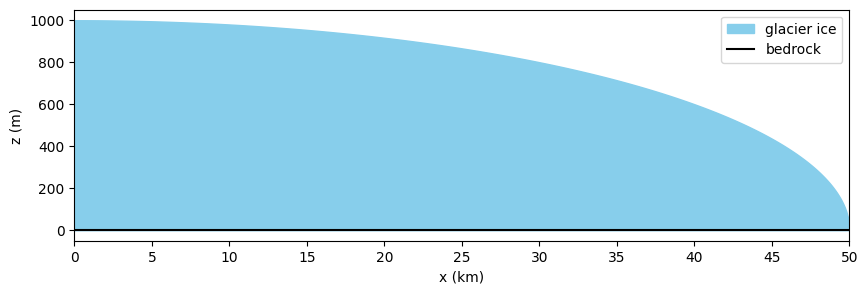

In [5]:
import matplotlib.pyplot as plt

x_truncated = np.where(np.isnan(s), np.nan, x)

plt.figure(figsize = (10, 3))
plt.fill_between(x, s, b, color = 'skyblue', label = 'glacier ice')
plt.plot(x, b, color = 'k', label = 'bedrock')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
ticks_m = np.arange(np.nanmin(x_truncated), np.nanmax(x_truncated) + 1, (np.nanmax(x_truncated) - np.nanmin(x_truncated))/10)
ticks_km = (ticks_m/1e3).astype(int)
plt.xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
plt.xticks(ticks_m, ticks_km)
plt.legend(loc = 'upper right')

plt.show()

We will eventually want to evaluate solutions over this 2D grid, and these solutions will often be functions of the surface and basal elevation profiles. Therefore, it will be useful to store copies of ```s``` and ```b``` that have the same shape as ```X``` and ```Z```. For example, for surface elevations, we can create a new array, capital ```S``` that is ```nz```-by-```nx```, such that every vertical layer of ```S``` is just a copy of ```s```. Do this, and do the same for capital ```B```. 

In [6]:
S = np.array([s for layer in X])
B = np.array([b for layer in X])

Before moving onto the actual glacier modeling, we conclude this section by creating our ```ice_mask```. Since the grid we've defined includes the entire rectangular $x$-$z$ domain, some of the grid cells will not fall on the glacier cross-section. To avoid evaluating our eventual solutions at these points, we can categorize each grid cell as ```True``` if that point falls within our glacier outline, and ```False``` otherwise. Do this simply by entering ```ice_mask = (Z >= B) & (Z <= S)```. *What would happen here if we tried to use ```s``` and ```b``` instead of ```S``` and ```B```?*

In [7]:
ice_mask = (Z >= B) & (Z <= S) #identify the part of the grid that actually occupies the ice-covered area above

In the Shallow Ice Approximation, flow is driven by thickness and surface slope, which means that the glacier moves the fastest where (a) the ice is thickest, and (b) the surface is steepest. In this case, without more information, it's difficult to know what to expect, since the steepest parts of our glacier occur where it is the thinnest. It's now necessary to get into the specifics of the flow model. 

### (ii) Shallow Ice Approximation: Stress solution

In our 2D setup, we can avoid beginning from the full Navier-Stokes equations, and start instead from the following *hydrostatic flowline model* of Equation 1. 

\begin{equation}2\frac{\partial}{\partial x}\tau_x +  \frac{\partial}{\partial z}\tau_z = \rho gs'\tag{1}\end{equation}

In this already-reduced form of Navier-Stokes, several key terms are present:

> - **$\rho$** — the density of ice, typically taken to be 917 kg/m$^3$. Define this variable below. 

In [8]:
ρ = 917 #ice density (kg/m^3)

> - **$g$** — the gravitational constant, 9.81 N/kg (often written in units of acceleration). Define this variable below. 

In [9]:
g = 9.81 #gravitational constant (N/kg)

> - **$s'$** — the surface slope in the $x$ direction, equivalently written $\frac{\partial s}{\partial x}$. Compute this derivative using [numpy.gradient](https://numpy.org/doc/2.1/reference/generated/numpy.gradient.html). 

In [10]:
s_prime = np.gradient(s, x)

> - **$\tau_{x}$** and **$\tau_{z}$** — extensional and shear stresses. These terms describe how ice is pushed and deformed in different directions.

Equation 1 demonstrates a relationship between stresses within the ice, on the left, and the gravitational driving force from the surface slope, $s'$, on the right. It is the stress terms which produce the velocity field we will eventually compute. 

## FAEZEH MAYBE CAN ELABORATE ON THIS FIGURE, WHICH I BELIEVE SHOULD ALREADY BE FAMILIAR TO THE STUDENTS? 

![Figure](shallow_ice_approximation_figure_2.jpg)




The two stress terms vary in their significance, depending on the particular glacier setting. $\tau_x$ describes tension and stretching forces, which are important for fast-moving glaciers on slippery bedrock. In glacier settings dominated by $\tau_x$, the bedrock provides little resistance to motion, and the glacier is free to speed up significantly along-flow, with the front moving considerably faster than ice upstream. $\tau_z$, conversely, describes shear forces acting on the ice, which are most significant when a glacier's base is stuck to the bedrock. In glacier settings dominated by $\tau_z$, the glacier terminus may still flow faster than ice upstream, but the most pronounced velocity differences are vertical: most motion occurs near the top surface, while the bedrock resists flow at depth. **This latter situation is the one considered by the Shallow Ice Approximation.** 

In the Shallow Ice Approximation, therefore, $\tau_z$ is of primary significance, and the stress term $\tau_x$ is considered negligible in contrast. We can now reduce Equation 1 by removing the first term, and then integrating vertically to the surface $s$. This provides the basis for the Shallow Ice Approximation:

\begin{equation}\tau_z = -\rho g(s - z)s'\tag{2}\end{equation}

Although our goal will be to describe the *velocity field* within the ice, it can help build intuition to visualize the stress that gives rise to that velocity. From Equation 2, we can already evaluate the shear stress $\tau_z$ at our grid points and plot. Define ```τ_z``` using Equation 2. To avoid values not on the ice itself, filter this variable using the previously-defined ```ice_mask```. Try using [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to set values of ```τ_z``` to NaNs if they are not within the ice domain. Syntax is ```output_array = numpy.where(boolean_condition, true_value, false_value)```. 

Plot ```τ_z``` within the glacier cross-section. One possibility is to use [matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html).

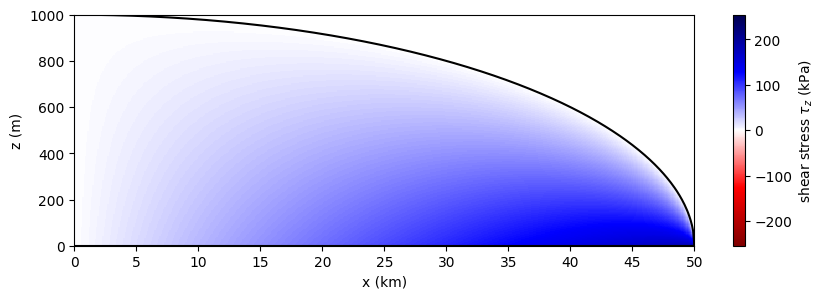

In [11]:
τ_z = -ρ*g*(S - Z)*s_prime
τ_z = np.where(ice_mask, τ_z, np.nan) #nan out any values of τ_z that fall outside the ice-covered area

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter = 0)

plt.figure(figsize=(10, 3))
stress_plot = plt.pcolormesh(x, z, τ_z/1e3, cmap = 'seismic_r', norm = norm)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
plt.xticks(ticks_m, ticks_km)
plt.ylim(np.nanmin(b), np.nanmax(s))
plt.colorbar(stress_plot, label = 'shear stress $τ_z$ (kPa)')
plt.show()

We can see that the shear stress is most pronounced *near the bed beneath the steepest parts of the glacier*. This makes sense, since flow is driven by surface slope, and the bed is the primary obstacle providing resistance to that flow. Looking at Equation 2, we should expect that $\tau_z$ increases linearly with depth. Verify this by plotting a vertical cross-section of the stress solution at some fixed $x$ coordinate.

## CAN BE REMOVED??

In [12]:
x_1 = 0.5*x_t #choose the point x_1, along which we'll plot a vertical cross-section

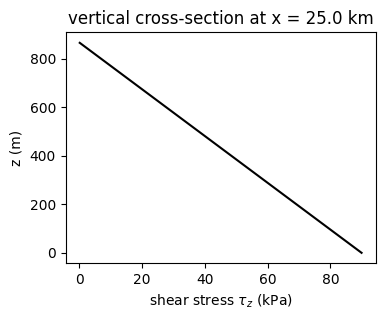

In [13]:
i_x1 = np.argmin(np.abs(x - x_1))  #find nearest x-index
τ_z1 = τ_z[:, i_x1]/1e3 #evaluate τ_z at each vertical position along that index, in kPa

plt.figure(figsize = (4, 3))
plt.plot(τ_z1, z, color = 'k')
plt.xlabel('shear stress $τ_z$ (kPa)')
plt.ylabel('z (m)')
plt.title(f'vertical cross-section at x = {x_1/1e3:.1f} km')
plt.show()

### (iii) Constitutive relation: Glen's Flow Law

In solid mechanics, applying a stress to an object causes deformation, and that deformation is undone once the force is removed. For example, think of applying a tensile force to pull a spring apart: the spring stretches, but reverts to its baseline as soon as you let go. In contrast, applying the same force to a fluid causes permanent deformation which continues to accumulate at a certain rate for as long as the stress is applied. 

For ice, the relationship between the deformation rate and the applied stress is given by *Glen's Flow Law*. For the Shallow Ice Approximation, Glen's Flow Law states that the shear stress $\tau_z$ causes the flow velocity, $u$, to vary with depth via the power law relationship below.

\begin{equation}
\frac{\partial}{\partial z}u = 2A|\tau_z|^{n - 1}\tau_z
\tag{3}
\end{equation}

Here, $n$ is the *flow exponent*, which is typically taken by glaciologists to be 3. The *rate factor* $A$ is a measure of ice malleability, with larger values corresponding to softer, less rigid ice. $A$ relates to temperature, $T$, via the *Arrhenius relation* below: 

\begin{equation}
A = A_0 e^{-\frac{Q}{R}(\frac{1}{T} - \frac{1}{T_t})}
\tag{4}
\end{equation}

In this relation, $A_0$ is the *prefactor*, the empirically-determined value of $A$ for ice at the *transition temperature* $T_t$. $Q$ is a temperature-dependent *activation energy* which depends on ice temperature. $R$ is the *gas constant*. Typical values for these variables are given below:

> $A_0 = 3.5 \times 10^{-25}$ s$^{-1}$Pa$^{-n}$
>
> $T_t = 263$ K
>
> $Q = 6\times 10^4$ J mol$^{-1}$ for temperatures below $T_t$; otherwise $Q = 115\times 10^3 $J mol$^{-1}$
>
> $R = 8.314$ J mol$^{-1}$ K$^{-1}$

Choose a reasonable ice temperature and calculate $A$.

In [14]:
temp_C = 0 #ice temperature in Celsius

In [15]:
temp_K = temp_C + 273.15 #temperature in Kelvin
T_t = 263.15 #transition temperature (K)
Q = 6e4 if temp_K < T_t else 115e3 #activation enegy (J/mol), depends on temperature
A_0 = 3.5e-25 #rate prefactor (s^-1 Pa^-3)
R = 8.314 #gas constant (J mol^-1 K^-1)
n = 3 #flow exponent

A = A_0*np.exp(-Q/R*(1/temp_K - 1/T_t)) #final rate factor (s^-1 Pa^-3)

### (iv) Horizontal velocity solution

With the rate factor now a known quantity, we can obtain an analytic solution for the horizontal velocity $u$ by substituting $\tau_z$ from Equation 2 into the right-hand side of Equation 3, and then integrating vertically from the glacier base. This produces

\begin{equation}
u = \frac{-2A}{n + 1}(\rho g s')^{n - 1}\rho gs'\left([s - b]^{n + 1} - [s - z]^{n + 1}\right)
\tag{5}
\end{equation}

Evaluate this over the grid, and adjust your solution into metres per year. Use ```numpy.where``` to constrain the solution to the ice domain, setting any outlying values to NaNs. Plot the 2D solution. What physical units does the resulting velocity have? In glaciology, it is most common to represent ice flow in metres per day or metres per year (and for extremely fast-flowing glaciers, kilometres per year). 

In [16]:
u = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((S - B)**(n + 1) - (S - Z)**(n + 1)) #equation 5
u *= 60*60*24*365.25 #m/s -> m/yr
u = np.where(ice_mask, u, np.nan) #nan out any off-ice values

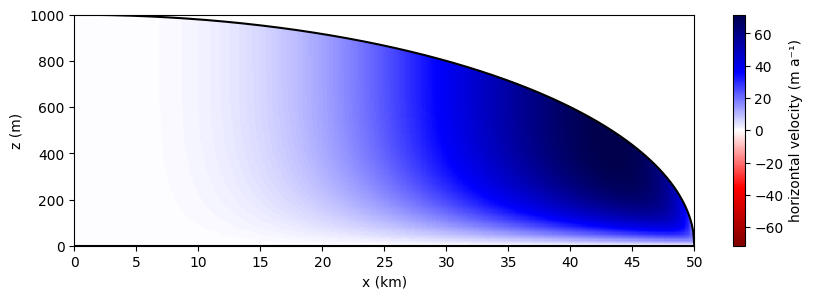

In [17]:
plt.figure(figsize=(10, 3))
norm = TwoSlopeNorm(vcenter = 0)
u_plot = plt.pcolormesh(X, Z, u, cmap = 'seismic_r', norm = norm)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.ylim(np.nanmin(b), np.nanmax(s))
plt.xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
plt.xticks(ticks_m, ticks_km)
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.colorbar(u_plot, label = 'horizontal velocity (m a⁻¹)')
plt.show()

As with the vertical shear stress, we can look at a single cross-section to try to build intuition about how velocity changes with depth. Beginning with the shear stress cross-section plot from earlier, try using ```matplotlib.pyplot.twiny``` to create a second $x$-axis for the velocity.

## CAN BE REMOVED AS WELL??

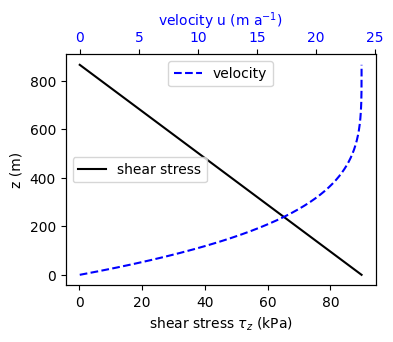

In [18]:
plt.figure(figsize = (4, 3))
plt.plot(τ_z1, z, color = 'k', label = 'shear stress')
plt.xlabel('shear stress $τ_z$ (kPa)')
plt.ylabel('z (m)')
plt.legend(loc = 'center left')

plt.twiny()

plt.plot(u[:, i_x1], z, color = 'blue', linestyle = 'dashed', label = 'velocity')
plt.xlabel('velocity u (m a$^{-1}$)', color = 'blue')
plt.xticks(color = 'blue')
plt.legend(loc = 'upper center')

plt.show()

If we look near the surface, the velocity of the ice doesn't change much with depth at first. As we approach the bed, however, velocity begins to rapidly slow down. How does this compare with the values of the shear stress near the surface? Near the base? Does this plot make sense alongside the interpretation that *basal shear stress resists flow*?

## Exercise: Velocity dependence on temperature and thickness

## **THIS SENSITIVITY STUDY PART IS NEW. MAYBE TOO DIFFICULT??**

How do ice temperature and thickness influence the speed at which ice flows? To address these questions, first look at the fastest-moving part of the glacier. What is the maximum speed of the glacier, given the parameters chosen above? We can figure this out by taking the maximum value of the array ```u```. Because we've clipped ```u``` to the ice mask, this will require handling NaNs. 

In [19]:
print(f'max velocity = {np.nanmax(np.abs(u)):.2f} m per year')

max velocity = 71.56 m per year


Now devise a way to examine the effect that *different temperatures* have on the maximum velocity, while keeping all other parameter choices constant. To avoid overwriting variables, do this as a function of the form

    def maximum_velocity(...):
        ...
        ...
        u_max = ...
        return u_max

Use this function to create a graph of temperature vs. maximum velocity for temperatures between $-20 \degree$ C and $0 \degree$ C. 

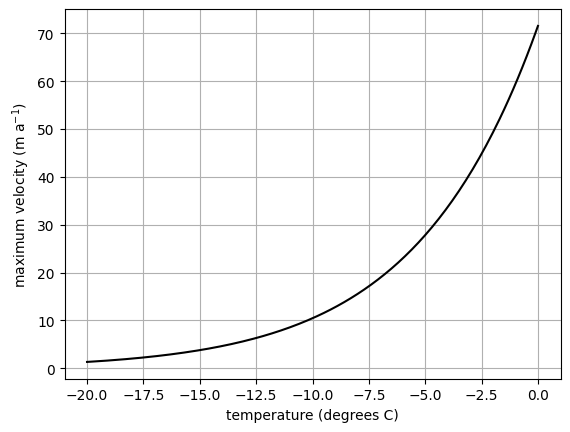

In [20]:
def maximum_velocity(**kwargs):
    
    T = kwargs['temperature']
    T = np.atleast_1d(T) #optional: make the function robust enough to handle both scalar and array arguments
    T = T[:, None, None] #in this case, the shape needs to work with s_prime, S, and B
    
    temp_K = T + 273.15 #convert to Kelvin
    A = A_0*np.exp(-Q/R*(1/temp_K - 1/T_t)) #recalculate A
    
    u = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((S - B)**(n + 1) - (S - Z)**(n + 1)) #and recalculate u
    u *= 60*60*24*365.25 #m/s -> m/yr
    u = np.where(ice_mask, u, np.nan) 
    
    u_max = np.nanmax(np.abs(u), axis = (1, 2)) #determine the max value of each velocity solution
    return u_max #will match the shape of "temperature"

temperatures = np.arange(-20, 1e-10, 0.1)
velocities = maximum_velocity(temperature = temperatures)

plt.figure()
plt.plot(temperatures, velocities, color = 'k')
plt.xlabel('temperature (degrees C)')
plt.ylabel('maximum velocity (m a$^{-1}$)')
plt.grid()

Now modify the function you just created by including "apex" as an additional argument. "Apex" here should determine the highest point of the dome shape - what we called ```max_height``` earlier. Given an input temperature and thickness, the function should return the maximum velocity throughout the glacier domain. 

In [21]:
def maximum_velocity(**kwargs):
    
    T = kwargs['temperature'] 
    T = np.atleast_1d(T)
    T = T[:, None, None]

    max_height = kwargs['apex'] #scalar value

    s = 1/x_t*max_height*np.sqrt(x_t**2 - x**2) #the shape of the glacier surface will now be different
    s_prime = np.gradient(s, x) #and, therefore, the slope
    S = np.array([s for layer in X]) #don't forget capital S...
    ice_mask = (Z >= B) & (Z <= S) #...and the new ice mask
    
    temp_K = T + 273.15 #recalculate A
    A = A_0*np.exp(-Q/R*(1/temp_K - 1/T_t)) 
    
    u = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((S - B)**(n + 1) - (S - Z)**(n + 1)) #recalculate u
    u *= 60*60*24*365.25 #m/yr
    u = np.where(ice_mask, u, np.nan) 
    
    u_max = np.nanmax(np.abs(u), axis = (1, 2)) #determine the max value
    return u_max

Now investigate the joint sensitivity of maximum velocity to both temperature and thickness using ```matplotlib.pyplot.contourf```. Create a plot with temperature spanning from $-20 \degree$ C to $0 \degree$ C along the horizontal axis, apex height spanning from $100$ m to $2000$ m along the vertical axis, with the plot filled in with colours corresponding to ```u_max```. It may help to use a logarithmic colourbar.  

/tmp/ipykernel_2728538/1825571359.py:9: RuntimeWarning: invalid value encountered in sqrt
  s = 1/x_t*max_height*np.sqrt(x_t**2 - x**2) #the shape of the glacier surface will now be different


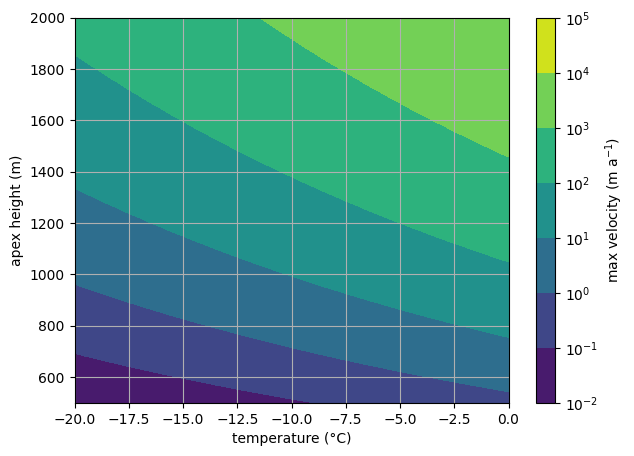

In [22]:
temperatures = np.arange(-20, 0 + 1e-10, 1)          
heights  = np.arange(500, 2000 + 1e-10, 10)   
T_grid, H_grid = np.meshgrid(temperatures, heights)
u_max = [maximum_velocity(temperature = temperatures, apex = H) for H in heights]

from matplotlib.colors import LogNorm

plt.figure(figsize=(7, 5))
sensitivity_plot = plt.contourf(T_grid, H_grid, u_max, norm = LogNorm(), levels = np.logspace(-2, 5, 8))
plt.colorbar(sensitivity_plot, label = 'max velocity (m a$^{-1}$)')
plt.xlabel('temperature (°C)')
plt.ylabel('apex height (m)')
plt.grid()
plt.show()

### (v) Strain rates 

In the case above, ice near the terminus (the right side) is flowing more quickly than ice upstream (the left side). You can imagine that, if this continues over time, the shape of the glacier will become longer. The rate of lengthening is often symbolized $\dot{\varepsilon}_x$ (the *longitudinal strain rate*) and it is simply the gradient of the horizontal velocity in the $x$ direction:

\begin{equation}
\dot{\varepsilon}_{x} = \frac{\partial}{\partial x}u
\tag{6}
\end{equation}

Create a variable called ```ε_x``` using Equation 6 and ```numpy.gradient```. Note that ```numpy.gradient``` sometimes behaves strangely with NaNs, so it may be helpful to first create a copy of ```u``` where the outlying values are zeros, rather than NaNs. 

In [23]:
ε_x = np.gradient(np.where(ice_mask, u, 0), x, axis = 1) #horizontal stretching rate

Whenever ice speeds up in the along-flow direction, the velocity gradient is positive, producing a positive lengthening rate $\dot{\varepsilon}_{x}$. In some situations, flow may slow down along-flow, in which case $\dot{\varepsilon}_{x}$ is negative, and the glacier becomes shorter.

However, ice is an *incompressible material*. This means that (unless the glacier undergoes accumulation or melt) total volume must not change: any lenthening in the horizontal direction must be associated with thinning in the vertical direction. Therefore, we also need to consider the vertical strain rate, $\dot{\varepsilon}_{z}$. Similar to the definition of the longitudinal strain rate, the vertical strain rate is just

\begin{equation}
\dot{\varepsilon}_{z} = \frac{\partial}{\partial z}w,
\tag{7}
\end{equation}

where $w$ is the vertical velocity component: the rate at which glacier ice flows upward or downward to balance any horizontal extension. In our 2D cross-section, there is a particularly simple relationship describing the balance between the horizontal and vertical strain rates: 

\begin{equation}
\dot{\varepsilon}_{x} + \dot{\varepsilon}_{z} = 0
\tag{8}
\end{equation}

That is, the net rate of stretching between the horizontal and the vertical must be zero. This means that we can directly calculate the vertical strain rate. Do so below with ```ε_z```. 

In [24]:
ε_z = -ε_x #vertical thinning rate, by Equation 8

### (vi) Vertical velocity solution

From here, we can use Equation 6 to recover the vertical velocity field itself, $w$. We can do this numerically, by taking cumulative summations of $\dot{\varepsilon}_z$ over the domain. Once $w$ is computed, make sure to set any appropriate values to NaNs. 

In [25]:
Δz = np.mean(np.diff(z))
w = np.cumsum(ε_z, axis = 0)*Δz #vertical velocity as the weighted cumulative summations of ε_z, by Equation 7
w = np.where(ice_mask, w, np.nan)

We can now plot the horizontal and vertical velocities together as subplots, vertically stacked, with a shared $x$ axis. Initialize 2-by-1 subplots using ```fig, axs = matplotlib.pyplot.subplots(2, 1, figsize = (10, 6), sharex = True)```. The top subplot is indexed as ```axs[0]```, and the bottom will be indexed as ```axs[1]```. [See here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) for more information on ```matplotlib.pyplot.subplots```. 

## MAYBE THIS PART CAN BE REMOVED - THE STREAMPLOT LATER IS PROBABLY MORE INTERESTING TO LOOK AT

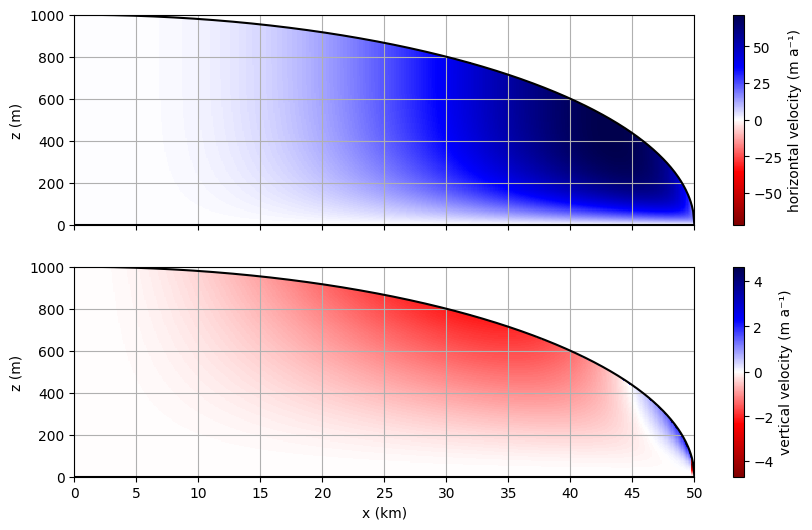

In [26]:
fig, axs = plt.subplots(2, 1, figsize = (10, 6), sharex = True)

###########################
### horizontal velocity ###
###########################

norm = TwoSlopeNorm(vcenter = 0)
u_plot = axs[0].pcolormesh(X, Z, u, norm = norm, cmap = 'seismic_r')
axs[0].plot(x, s, color = 'k')
axs[0].plot(x, b, color = 'k')
axs[0].set_ylim(np.nanmin(b), np.nanmax(s))
axs[0].set_xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
axs[0].set_xticks(ticks_m, ticks_km)
axs[0].set_ylabel('z (m)')
axs[0].grid()
fig.colorbar(u_plot, ax = axs[0], label = 'horizontal velocity (m a⁻¹)')


#########################
### vertical velocity ###
#########################

norm = TwoSlopeNorm(vcenter = 0)
w_plot = axs[1].pcolormesh(X, Z, w, cmap='seismic_r', norm = norm)
axs[1].plot(x, s, color = 'k')
axs[1].plot(x, b, color = 'k')
axs[1].set_xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
axs[1].set_ylim(np.nanmin(b), np.nanmax(s))
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('x (km)')
axs[1].grid()
fig.colorbar(w_plot, ax=axs[1], label='vertical velocity (m a⁻¹)')

plt.show()

Notice that the vertical velocity is negative wherever ice is speeding up along-flow, and upward in the small near-terminus zone where $u$ is slowing down. *How does this observation relate to the concept of incompressibility? How does it relate to Equation 8?*

We can combine the data from both of these subfigures to plot the total speed (the magnitude of the velocity), and overlay this with a streamplot to more directly visualize the net flow direction. Create a variable called ```speed``` which is equal to $\sqrt{u^2 + w^2}$, and plot it. Overlay that plot with a streamplot generated with ```matplotlib.pyplot.streamplot```. 

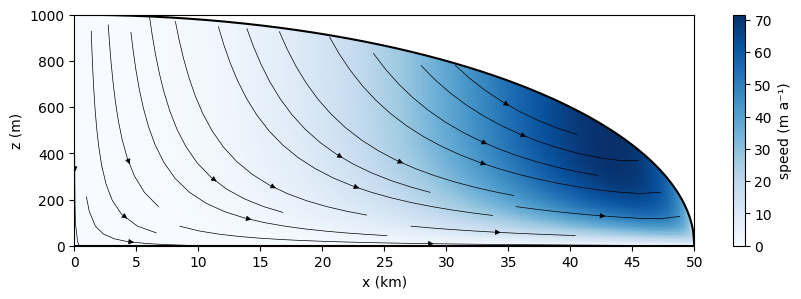

In [27]:
speed = np.hypot(u, w)

plt.figure(figsize = (10, 3))
speed_plot = plt.pcolormesh(X, Z, speed, cmap = 'Blues')
plt.streamplot(x, z, u, w, color = 'k', density = 2, linewidth = 0.5, arrowsize = 0.8)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
plt.ylim(np.nanmin(b), np.nanmax(s))
plt.xticks(ticks_m, ticks_km)
plt.colorbar(speed_plot, label = 'speed (m a⁻¹)')
plt.show()

### (vii) Glacier shape change

As you can probably imagine from the plot above, the motion described by the Shallow Ice Approximation redistributes ice, changing the shape of the glacier. For example, even without a description of melt or accumulation, the flowlines above show that the surface should lower and mass should move to the right. How might this impact how the glacier looks after some specified amount of time? 

We can think about this problem by considering the *ice flux*, or the total amount of ice conveyed forward through a vertical slice of the glacier. This quantity, often symbolized $q$, is given as the depth-integrated forward velocity, from the base to the surface, with 

\begin{equation}
q = \int_b^sudz
\tag{9}
\end{equation}

This has an analytic solution in terms of $u_s$, where $u_s$ is the surface velocity:

\begin{equation}
q = \frac{n + 1}{n + 2}u_s(s - b)
\tag{10}
\end{equation}

Evaluate the ice fluq $q$, looking back to Equation 5 to first obtain an expression for the surface velocity. In this case, it will be helpful to have ```q``` the same size as ```s```, rather than ```S```.

In [28]:
u_s = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((s - b)**(n + 1))*60*60*24*365.25 #equation 5 with z = s
q = (n + 1)/(n + 2)*u_s*(s - b)

Meanwhile, ice can also change shape due to climate conditions. In the highest reaches of a glacier, where it might be cold even in the summer, there is often more snowfall than there is melt, and the surface rises: this is the accumulation zone, where the *surface mass balance* (often symbolized $\dot{a}$) is positive. Toward the terminus, at lower elevation, melting may outweigh snowfall, and the surface lowers: this is the ablation zone, where the surface mass balance in negative. Somewhere in between is the Equilibrium Line Altitude, or ELA: the region where snowfall and melt exactly cancel each other out so that $\dot{a} = 0$.  

In the treatment below, we'll assume that the mass balance of the glacier is a function of elevation alone: zero at the ELA, with the surface mass balance increasing by some lapse rate for each metre above that elevation (and decreasing downward at the same rate). Choose an ELA by defining ```ela``` as some elevation up the glacier. To obtain a reasonable lapse rate, try setting ```lapse_rate = numpy.nanmax(w)/numpy.nanmean(s)``` (this is just to ensure that the accumulation/melt rates are comparable to the rates of dynamic thickening/thinning from vertical flow). Finally, define ```a_dot``` as an array with the surface mass balance values corresponding to these parameter choices. This array stores a value for each point along the surface, so it must have the same size as ```s```. 

In [29]:
ela = max_height*0.8 #height of the equilibrium line altitude
lapse_rate = np.nanmax(w)/np.nanmean(s) # + np.nanstd(abs_εz)
a_dot = lapse_rate*(s - ela)

In [30]:
####################################################
### CREATE THE FIGURE AT THE TOP OF THE NOTEBOOK ###
####################################################

# plt.figure(figsize = (10, 3))
# plt.fill_between(x, b, s, color = 'skyblue', label = 'glacier ice')
# plt.plot(x, b, color = 'k')

# weight = 1/10*max_height/np.nanmax(np.abs(a_dot))
# plt.fill_between(x[a_dot < 0], s[a_dot < 0], s[a_dot < 0] + weight*a_dot[a_dot < 0], color = 'red', alpha = 0.5, label = 'melt')
# plt.fill_between(x[a_dot > 0], s[a_dot > 0], s[a_dot > 0] + weight*a_dot[a_dot > 0], color = 'blue', alpha = 0.5, label = 'snowfall')
# plt.axhline(ela, color = 'k', linestyle = 'dashed', label = 'ELA')

# z_col = np.linspace(b[i_x1], s[i_x1], 20)
# u_col = np.interp(z_col, z, u[:, i_x1])
# plt.quiver([x_1]*len(z_col), z_col, u_col, 0, color = 'k', width = 0.0025, label = 'ice flux')

# plt.ylim(0, )
# plt.xticks(ticks_m, ticks_km)
# plt.xlabel('x (km)')
# plt.ylabel('z (m)')
# plt.xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))
# plt.legend(loc = 'lower left')
# plt.grid()
# plt.show()

The rate of thickness change relates to ice flux via the mass conservation equation below. 

\begin{equation}
\dot{H} + \frac{\partial}{\partial x}q = \dot{a}
\tag{11}
\end{equation}

In this equation, we have symbolized the rate of thickness change over time as $\dot{H}$. This shows that the net rate of thickness change can be partitioned into two components: the *dynamic component*, $-\frac{dq}{dx}$, which results from the ice velocity, and the *environmental component*, $\dot{a}$, which is the surface mass balance rate. Below, compute $\dot{H}$ and create a plot to show this partitioning. It may be possible to do this in multiple ways. 

Where is SMB the dominant component? Where is ice dynamics dominant? Where do they cancel each other out? Where do they act additively?

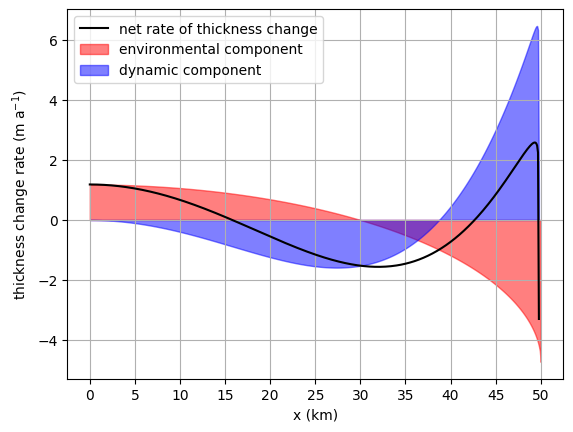

In [31]:
dq_dx = np.gradient(q, x)
H_dot = a_dot - dq_dx #by Equation 10

plt.figure()
plt.plot(x, H_dot, color = 'k', zorder = 3, label = 'net rate of thickness change')
plt.fill_between(x, np.zeros_like(x), a_dot, color = 'red', alpha = 0.5, label = 'environmental component')
plt.fill_between(x, np.zeros_like(x), -dq_dx, color = 'blue', alpha = 0.5, label = 'dynamic component')
plt.xticks(ticks_m, ticks_km)
plt.xlabel('x (km)')
plt.ylabel('thickness change rate (m a$^{-1})$')
plt.grid()
plt.legend()
plt.show()

Now, after flow continues for some small amount of time, $\Delta t$, the total amount of thickness change over that timespan is approximately $\dot{H}\Delta t$. The new surface elevation after a duration of $\Delta t$, therefore, can be estimated by modifying the old surface elevation by that amount:

\begin{equation}
s_{new} = s + \dot{H}\Delta t
\tag{11}
\end{equation}

Small timesteps are important when incrementally updating the surface elevation this way: if $\Delta t$ is large enough that $s$ changes substantially, then Equation 5 tells us that we should expect the velocity $u$ to have substantially changed as well - and, therefore, the ice flux $q$ (which depends on $u$ via Equation 9) and the rate of thickness change $\dot{H}$ (which depends on $q$ via Equation 10). In this case, Equation 11 would be a poor approximation. When modeling long timespans, therefore, it is important to take small timesteps and incrementally update each of these parameters successively. 

Choose a reasonably small timestep and plot the initial glacier profile alongside $s_{new}$.

## TAKE OUT THIS ANIMATION AND ONLY INCLUDE THE FIRST AND FINAL FRAMES

In [32]:
Δt = 0.1*max_height/np.nanmax(np.abs(H_dot)) #e.g., take Δt small enough that the largest thickness change is only 10% of the max thickness
num_substeps = 100
δt = Δt/num_substeps
s_new = s.copy() #initialize the new surface elevation as a copy of the old one

surface_evolution = []
for step in range(num_substeps + 1):
    s_new = s_new + H_dot*δt
    s_new[s_new < b] = np.nan #nan out any nonphysical values
    surface_evolution.append(s_new)

In [33]:
animation_time = 3 #how long we want the animation to run, in seconds

from matplotlib.animation import FuncAnimation
plt.rcParams['animation.html'] = 'jshtml'

fig, ax = plt.subplots(figsize = (10, 3))
fig.subplots_adjust(bottom = 0.2)
line, = ax.plot(x, surface_evolution[0], color = 'dodgerblue')
fill = ax.fill_between(x, b, surface_evolution[0], color = 'skyblue')

ax.plot(x, surface_evolution[0], color = 'k', linestyle = 'dashed', label = 'initial surface')
ax.plot(x, b, color = 'k')

buffer = 0.05*np.nanmax(s)
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmin(b), np.nanmax(s) + 2*buffer)
ax.set_xlim(np.nanmin(x_truncated), np.nanmax(x_truncated))

ax.set_xticks(ticks_m, ticks_km)
ax.set_xlabel('x (km)')
ax.set_ylabel('z (m)')
ax.legend()
ax.grid()

fill_art = [fill]  

def update(step):
    s_t = surface_evolution[step]
    line.set_ydata(s_t)
    fill_art[0].remove()
    fill_art[0] = ax.fill_between(x, b, s_t, color = 'skyblue')
    ax.set_title(f'time = {step*δt:.1f} years')
    return line, fill_art[0]

display_interval = (animation_time*1000)/len(surface_evolution)
ani = FuncAnimation(fig, update, frames = len(surface_evolution), interval = display_interval, blit = False)
plt.close(fig)
ani